# German Credit Dataset

## Import Packages

In [ ]:
%pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as py 
%matplotlib inline

from scipy.stats import skew

from sklearn.preprocessing import OneHotEncoder ,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , StratifiedKFold , GridSearchCV
from sklearn.metrics import classification_report , accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Read the data 

In [3]:
german_credit_dataset = pd.read_excel("german_credit_data.xlsx")
german_credit_dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
german_credit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [5]:
german_credit_dataset.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


## Unique Values 

In [6]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:")
print(unique_value(german_credit_dataset,list(german_credit_dataset.columns)))

Number of the Unique Values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


## Identifying Missing and Replacing 

In [7]:
# Identify missing values
missing_values = german_credit_dataset.isnull().sum().sort_values(ascending=False)

missing_values_df = pd.DataFrame({
    'Missing Values': missing_values.values,
    'Percentage Missing': (missing_values / len(german_credit_dataset)) * 100
})

# Print the DataFrame
print("\n", missing_values_df)



                   Missing Values  Percentage Missing
Checking account             394                39.4
Saving accounts              183                18.3
Age                            0                 0.0
Sex                            0                 0.0
Job                            0                 0.0
Housing                        0                 0.0
Credit amount                  0                 0.0
Duration                       0                 0.0
Purpose                        0                 0.0
Risk                           0                 0.0


In [8]:
german_credit_dataset['Risk'].replace({'good': 1, 'bad': 0}, inplace=True)

In [9]:
#Filling missing values with mode
german_credit_dataset["Saving accounts"].fillna(german_credit_dataset['Saving accounts'].mode()[0], inplace=True)
german_credit_dataset["Checking account"].fillna(german_credit_dataset['Checking account'].mode()[0], inplace=True)

## Identifying Numerical and Categorical Columns

In [10]:
# Separate columns into numerical and categorical
numerical_columns = german_credit_dataset.select_dtypes(include=['number']).columns
categorical_columns = german_credit_dataset.select_dtypes(include=['object']).columns

# Display the results
print("Numerical Columns:\n", numerical_columns)
print("\nCategorical Columns:\n", categorical_columns)

Numerical Columns:
 Index(['Age', 'Job', 'Credit amount', 'Duration', 'Risk'], dtype='object')

Categorical Columns:
 Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object')


In [11]:
numerical_columns = ['Age', 'Job', 'Credit amount', 'Duration']

In [12]:
# Display count of unique values in each feature

categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


for column in categorical_columns:
    unique_values_count = german_credit_dataset[column].value_counts()
    print(f"Feature: {column}\n{unique_values_count}\n{'-'*30}")

Feature: Sex
Sex
male      690
female    310
Name: count, dtype: int64
------------------------------
Feature: Housing
Housing
own     713
rent    179
free    108
Name: count, dtype: int64
------------------------------
Feature: Saving accounts
Saving accounts
little        786
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64
------------------------------
Feature: Checking account
Checking account
little      668
moderate    269
rich         63
Name: count, dtype: int64
------------------------------
Feature: Purpose
Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64
------------------------------


In [13]:
german_credit_dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,little,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


## One hot encoding for categorical variables 

In [14]:
# Select the categorical columns
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Use the fit_transform method to perform one-hot encoding
df_encoded_array = encoder.fit_transform(german_credit_dataset[categorical_columns].astype(str)).toarray()

# Create a DataFrame with the encoded features
df_encoded = pd.DataFrame(df_encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the new DataFrame with the original one, dropping the original categorical columns
data_encoded = pd.concat([german_credit_dataset, df_encoded], axis=1).drop(categorical_columns, axis=1)

# Display the resulting DataFrame
data_encoded.head()

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,2,5951,48,0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,49,1,2096,12,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,45,2,7882,42,1,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,2,4870,24,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualizing the histograms for numerical features

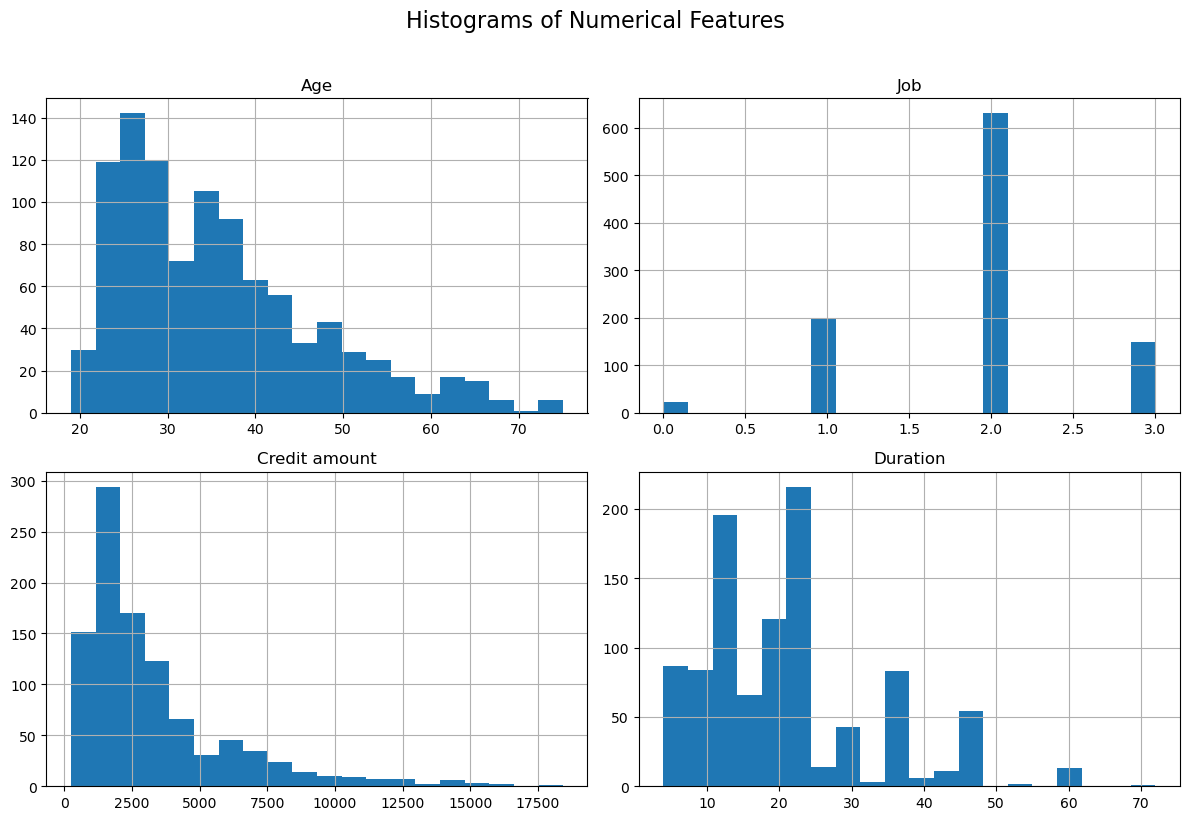

In [15]:
# Plot histograms for numerical features
german_credit_dataset[numerical_columns].hist(bins=20, figsize=(12,8))
py.suptitle("Histograms of Numerical Features", y=1.02, size=16)
py.tight_layout()
py.show()

## Obsrevation skewness in the data

In [16]:
skewness = german_credit_dataset[numerical_columns].apply(lambda x: skew(x))

# Display skewness values
print("Skewness of Numerical Features:\n", skewness)

# Identify features with skewness greater than a threshold (e.g., 0.5)
skewed_features = skewness[abs(skewness) > 0.25].index


Skewness of Numerical Features:
 Age              1.019208
Job             -0.373733
Credit amount    1.946702
Duration         1.092542
dtype: float64


## Applying Log Transformation to Skewed Features

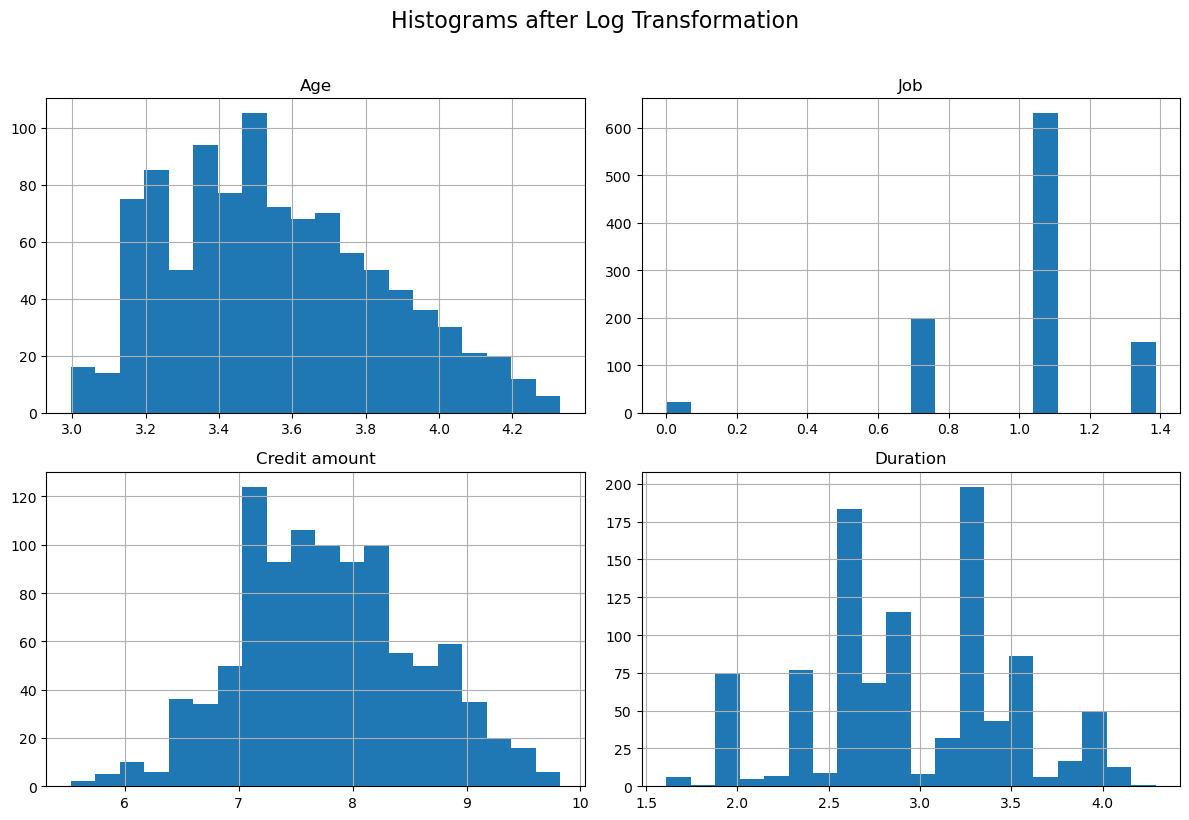

In [17]:
# Apply log transformation to skewed features
german_credit_dataset[skewed_features] = np.log1p(german_credit_dataset[skewed_features])

# Display histograms after log transformation
german_credit_dataset[skewed_features].hist(bins=20, figsize=(12,8))
py.suptitle("Histograms after Log Transformation", y=1.02, size=16)
py.tight_layout()
py.show()

## Applying Feature Scaling , Using MinMax Scaling on Numerical Columns

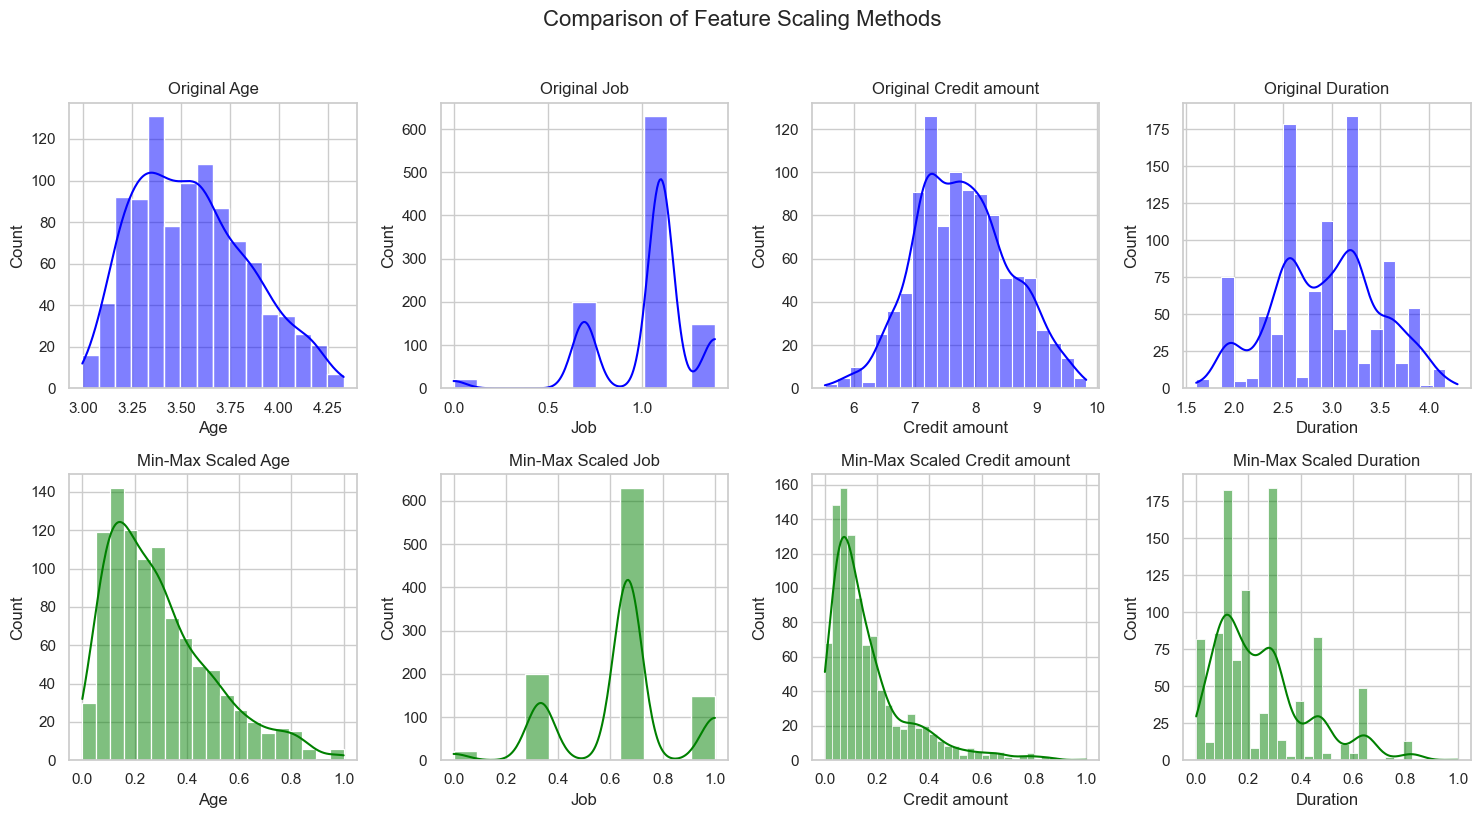

In [18]:
# Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_encoded_scaled = data_encoded.copy()
data_encoded_scaled[numerical_columns] = min_max_scaler.fit_transform(data_encoded_scaled[numerical_columns])

# Set the style for Seaborn
snb.set(style="whitegrid")

# Create subplots using Seaborn
fig, axes = py.subplots(nrows=2, ncols=len(numerical_columns), figsize=(15, 8))
fig.suptitle("Comparison of Feature Scaling Methods", y=1.02, size=16)

# Plot original distributions with KDE plots
for i, col in enumerate(numerical_columns):
    snb.histplot(german_credit_dataset[col], kde=True, color='blue', ax=axes[0, i])
    axes[0, i].set_title(f"Original {col}")

# Plot distributions after Min-Max Scaling with KDE plots
for i, col in enumerate(numerical_columns):
    snb.histplot(data_encoded_scaled[col], kde=True, color='green', ax=axes[1, i])
    axes[1, i].set_title(f"Min-Max Scaled {col}")

# Adjust layout
py.tight_layout()
py.show()

In [19]:
data_encoded_scaled.head()

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0.857143,0.666667,0.050567,0.029412,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.053571,0.666667,0.313690,0.647059,0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.535714,0.333333,0.101574,0.117647,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.464286,0.666667,0.419941,0.558824,1,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.607143,0.666667,0.254209,0.294118,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Numerical features for clustering

In [57]:
# Choose the number of clusters (you can adjust this)
num_clusters = 3

# Apply k-means clusteringz
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(data_encoded_scaled)

# Add the cluster labels to the original dataset
data_encoded_scaled['Cluster'] = clusters

data_encoded_scaled.head(5)

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Cluster
0,0.857143,0.666667,0.050567,0.029412,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
1,0.053571,0.666667,0.313690,0.647059,0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.535714,0.333333,0.101574,0.117647,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
3,0.464286,0.666667,0.419941,0.558824,1,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
4,0.607143,0.666667,0.254209,0.294118,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2


##  elbow method to find best number of clusters

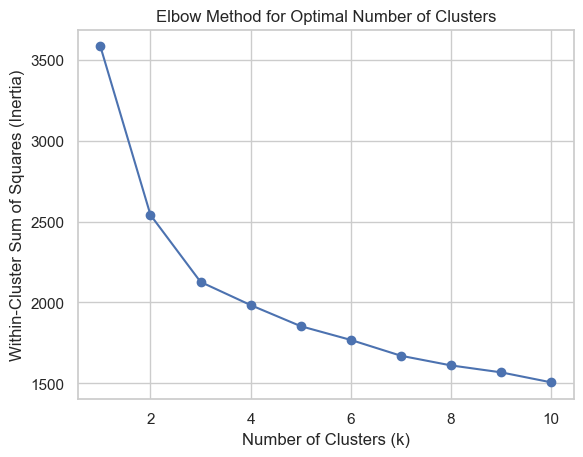

In [51]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_encoded_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow method graph with markers at potential elbow points
py.plot(range(1, 11), inertia_values, marker='o')
py.title('Elbow Method for Optimal Number of Clusters')
py.xlabel('Number of Clusters (k)')
py.ylabel('Within-Cluster Sum of Squares (Inertia)')
py.show()

## PCA

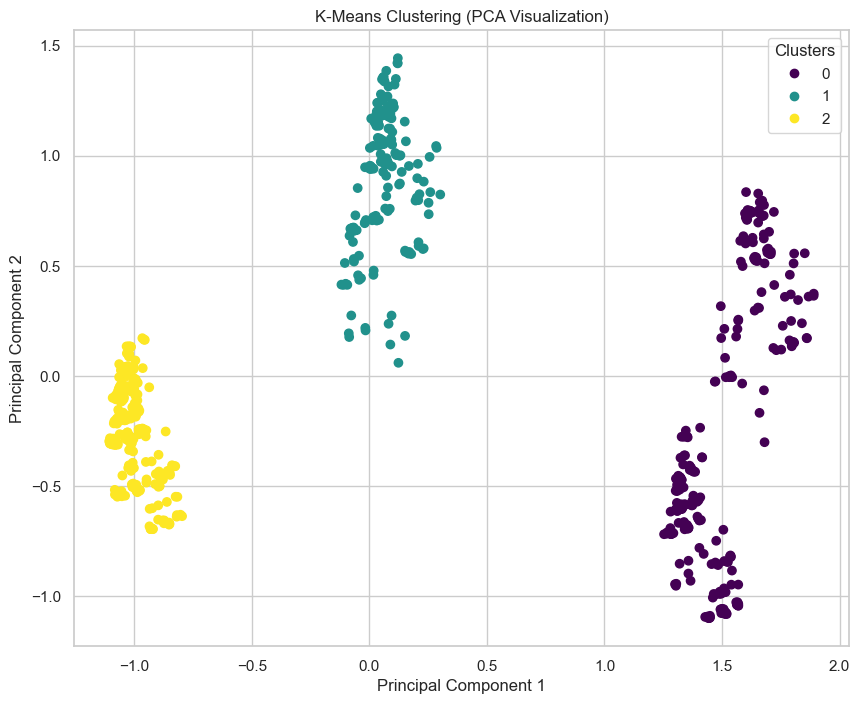

In [52]:
# Choose the optimum number of clusters (elbow point)
optimal_k = 3  

# Perform k-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(data_encoded_scaled)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_encoded_scaled)

# Visualize the clusters in 2D using PCA
py.figure(figsize=(10, 8))
scatter = py.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
py.title('K-Means Clustering (PCA Visualization)')
py.xlabel('Principal Component 1')
py.ylabel('Principal Component 2')
py.legend(*scatter.legend_elements(), title='Clusters')
py.show()

In [22]:
# Define your features (X) and target (y)
X = data_encoded.drop(columns=['Risk'])
y = data_encoded['Risk']

In [23]:
X.head()

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,2,5951,48,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,49,1,2096,12,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,45,2,7882,42,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,2,4870,24,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y.head()

0    1
1    0
2    1
3    1
4    0
Name: Risk, dtype: int64

## Splitting the data for training and testing 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

## Implementing KFOLD CV Using Xgboost classifier 

In [26]:
param_grid = {
    'max_depth': [5, 10, 25, 35, 50, 75, 125],
    'learning_rate': [0.05, 0.1, 0.2], 
    'n_estimators': [100, 150, 200, 250],
}

xgb_clf = XGBClassifier(objective='binary:logistic' , alpha =10 , random_state = 42 , n_jobs = -1)

# Implementing 5-fold KFold cross validation strategy
cv = StratifiedKFold(n_splits= 5 , shuffle=True , random_state=42)

# GridSearchCV object to find the best parameters
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=cv)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Accuracy: 0.7


In [27]:
#fit the classifier to the training data
xgb_clf.fit(X_train , y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [28]:
# make predictions on test data
x_pred = xgb_clf.predict(X_test)

In [29]:
# compute and print accuracy score

from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, x_pred)))

XGBoost model accuracy score: 0.7120


## Evaluation Matrics and Classifiaction Report

In [30]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-Score:", f1)

Test Accuracy: 0.7
Test Precision: 0.7032520325203252
Test Recall: 0.9885714285714285
Test F1-Score: 0.8218527315914489


In [31]:
grid_predictions = grid_search.predict(X_test) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.50      0.03      0.05        75
           1       0.70      0.99      0.82       175

    accuracy                           0.70       250
   macro avg       0.60      0.51      0.44       250
weighted avg       0.64      0.70      0.59       250



## Conclusion:

- The model performs well in predicting class 1 (good credit risk) with high recall, indicating that it effectively identifies positive instances.

- However, precision for class 1 is moderate, suggesting that there are some false positives.

- The model struggles with predicting class 0 (bad credit risk), as indicated by the low recall.

- The overall accuracy is reasonable, but it's important to consider the class imbalance when interpreting the results.
